## 1. Setup and Path Configuration

In [1]:
import json
import cv2
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List, Tuple
from pycocotools import mask as mask_utils

# ================= CONFIGURAÇÃO DE CAMINHOS =================
LOCAL_PATH = "/home/avmoura_linux/Documents/unb/sandbox_sam3"
LOG_DIR = Path(f"{LOCAL_PATH}/logs/ph2_train_seg_500")

CONFIG = {
    "train_stats": LOG_DIR / "train_stats.json",
    "val_stats": LOG_DIR / "val_stats.json",
    "best_stats": LOG_DIR / "best_stats.json",
    
    # Configurações do seu script de visualização
    "images_dir": Path(f"{LOCAL_PATH}/ph2_dataset/test/"),
    "pred_json": Path(f"{LOCAL_PATH}/logs/ph2_train_seg/dumps/ph2/coco_predictions_segm.json"),
    "gt_json": Path(f"{LOCAL_PATH}/ph2_dataset/test/_annotations.coco.json"),
    "score_threshold": 0.45,
    "mask_alpha": 0.45
}

## 2. Data Loading

In [2]:
def load_jsonl(filepath: Path) -> pd.DataFrame:
    if not filepath.exists():
        print(f"File not found: {filepath}")
        return pd.DataFrame()
        
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            if line.strip():
                data.append(json.loads(line.strip()))
    return pd.DataFrame(data)

# Carregando as métricas
df_train = load_jsonl(CONFIG["train_stats"])
df_val = load_jsonl(CONFIG["val_stats"])
df_best = load_jsonl(CONFIG["best_stats"])

print(f"Training lines loaded: {len(df_train)}")
print(f"Validation lines loaded: {len(df_val)}")

Training lines loaded: 500
Validation lines loaded: 101


## 3. Training Loss Analysis

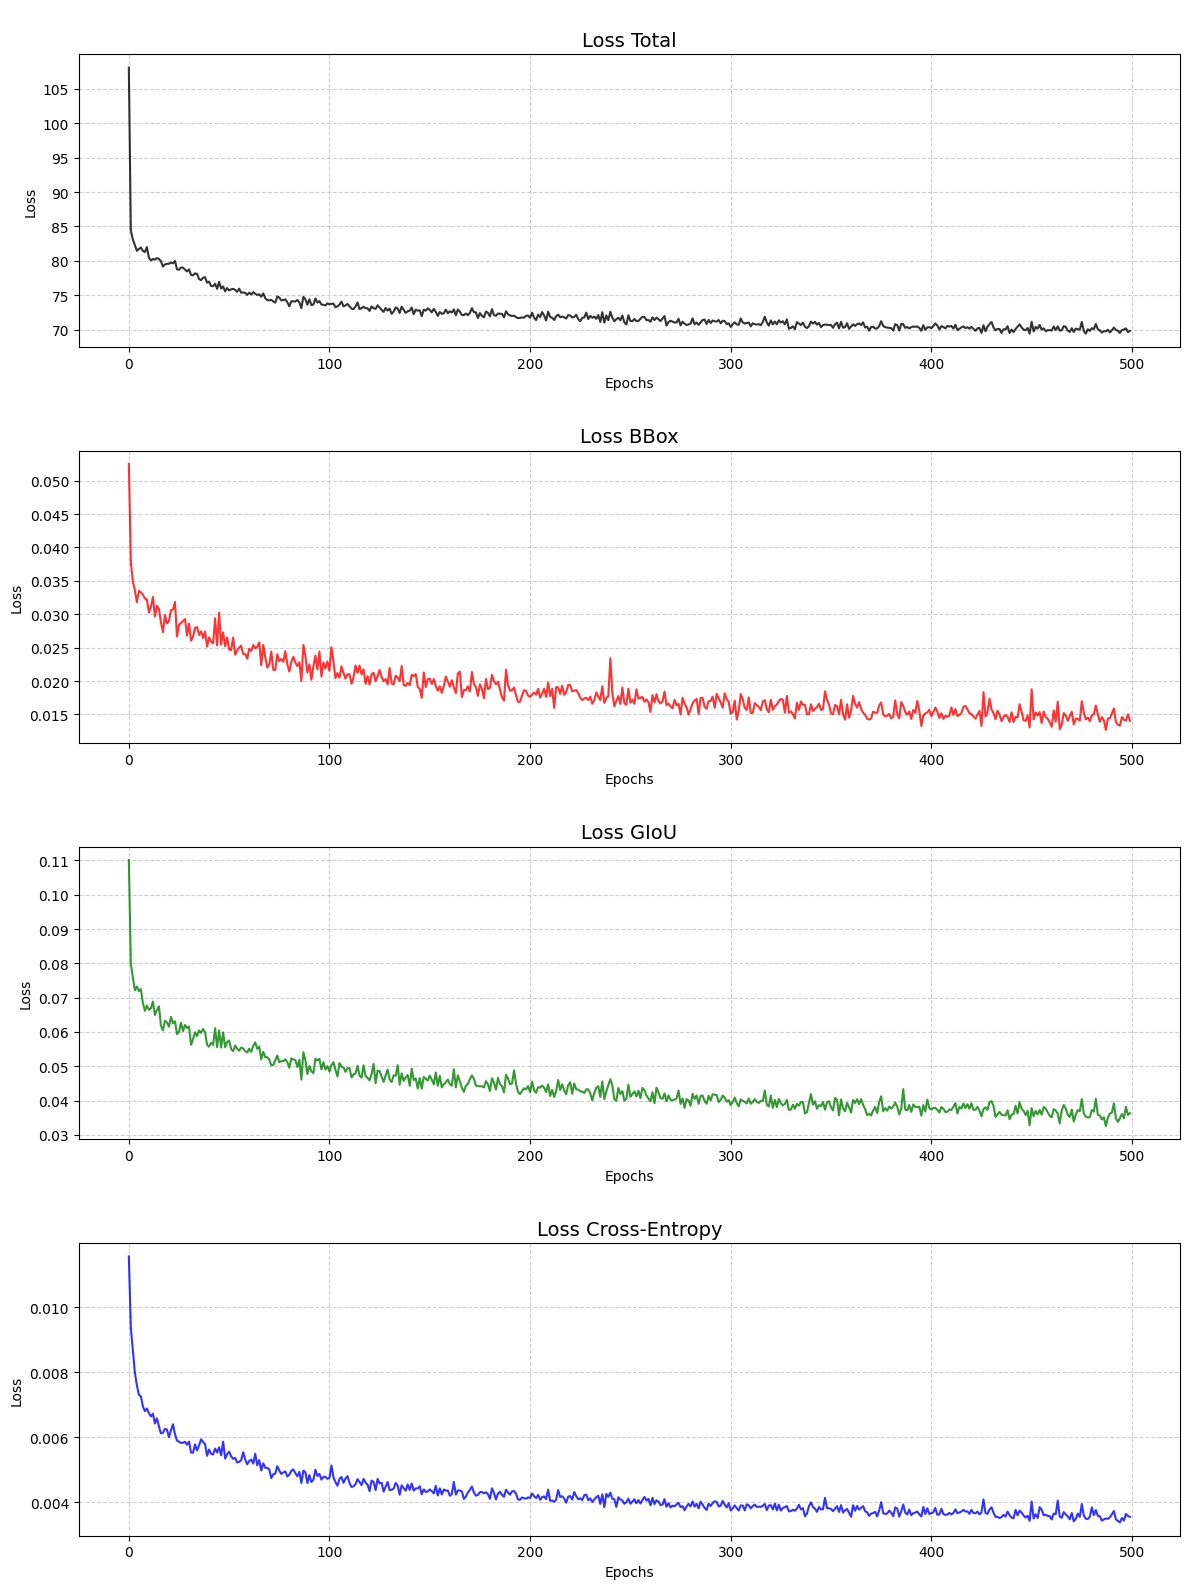

In [3]:
# Definindo as métricas principais de treino que queremos observar
train_metrics = {
    "\nLoss Total": ("Losses/train_all_loss", "black"),
    "\nLoss BBox": ("Losses/train_all_loss_bbox", "red"),
    "\nLoss GIoU": ("Losses/train_all_loss_giou", "green"),
    "\nLoss Cross-Entropy": ("Losses/train_all_loss_ce", "blue")
}

fig, axes = plt.subplots(len(train_metrics), 1, figsize=(12, 4 * len(train_metrics)))

for i, (title, (col_name, color)) in enumerate(train_metrics.items()):
    if col_name in df_train.columns:
        axes[i].plot(df_train.index, df_train[col_name], color=color, alpha=0.8)
        axes[i].set_title(title, fontsize=14)
        axes[i].set_xlabel("Epochs")
        axes[i].set_ylabel("Loss")
        axes[i].grid(True, linestyle="--", alpha=0.6)
    else:
        axes[i].text(0.5, 0.5, f"Metric {col_name} not found", ha="center", va="center")

plt.tight_layout()
plt.show()

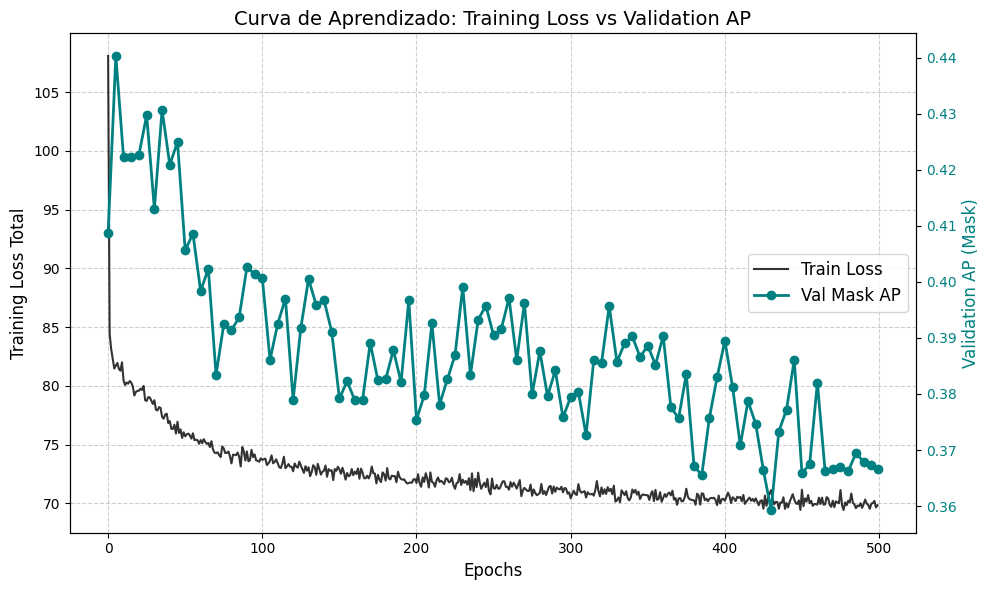

In [9]:
## 3. Loss de Treino vs AP de Validação
epochs_train = df_train['Trainer/epoch'] if 'Trainer/epoch' in df_train.columns else df_train.index
epochs_val = df_val['Trainer/epoch'] if 'Trainer/epoch' in df_val.columns else df_val.index

fig, ax1 = plt.subplots(figsize=(10, 6))

# Eixo Y Esquerdo: Loss de Treino
color1 = 'black'
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('Training Loss Total', color=color1, fontsize=12)
if "Losses/train_all_loss" in df_train.columns:
    ax1.plot(epochs_train, df_train["Losses/train_all_loss"], color=color1, label="Train Loss", alpha=0.8)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, linestyle="--", alpha=0.6)

# Eixo Y Direito: AP de Validação (Mask ou BBox)
ax2 = ax1.twinx()  # Instancia um segundo eixo Y que compartilha o mesmo eixo X
color2 = 'teal'
ax2.set_ylabel('Validation AP (Mask)', color=color2, fontsize=12)
# Vamos usar a AP de segmentação como métrica principal de sucesso
val_metric = 'Meters_train/val_ph2_eval/detection/coco_eval_segm_AP'
if val_metric in df_val.columns:
    ax2.plot(epochs_val, df_val[val_metric], color=color2, marker='o', label="Val Mask AP", linewidth=2)
ax2.tick_params(axis='y', labelcolor=color2)

# Adicionando as legendas de ambos os eixos juntas
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='center right', fontsize=12)

plt.title("Curva de Aprendizado: Training Loss vs Validation AP", fontsize=14)
plt.tight_layout()
plt.show()

## 4. Validation Metrics (COCO Evaluation)

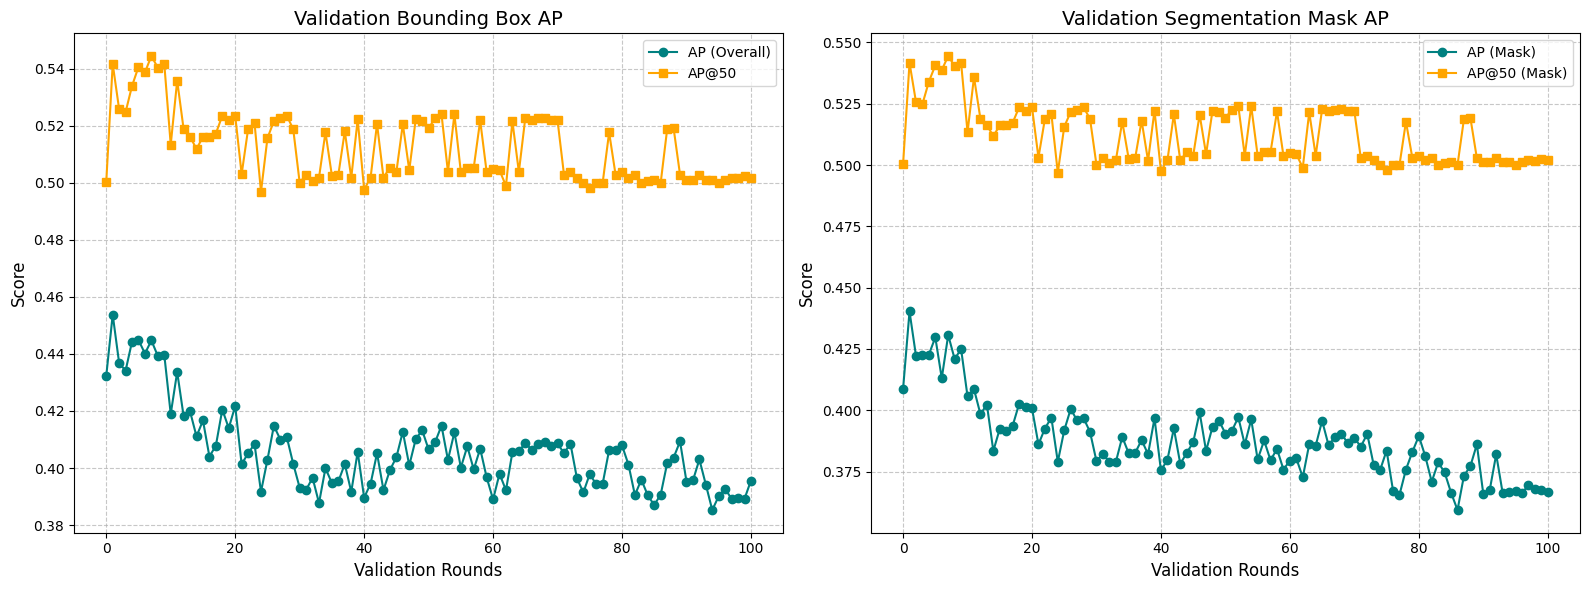

In [5]:
if not df_val.empty:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Bounding Box Average Precision
    bbox_ap = 'Meters_train/val_ph2_eval/detection/coco_eval_bbox_AP'
    bbox_ap50 = 'Meters_train/val_ph2_eval/detection/coco_eval_bbox_AP_50'
    
    if bbox_ap in df_val.columns:
        axes[0].plot(df_val.index, df_val[bbox_ap], label='AP (Overall)', marker='o', color='teal')
        axes[0].plot(df_val.index, df_val[bbox_ap50], label='AP@50', marker='s', color='orange')
    axes[0].set_title('Validation Bounding Box AP', fontsize=14)
    axes[0].set_xlabel('Validation Rounds', fontsize=12)
    axes[0].set_ylabel('Score', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.7)
    
    # Segmentation Mask Average Precision
    segm_ap = 'Meters_train/val_ph2_eval/detection/coco_eval_segm_AP'
    segm_ap50 = 'Meters_train/val_ph2_eval/detection/coco_eval_segm_AP_50'
    
    if segm_ap in df_val.columns:
        axes[1].plot(df_val.index, df_val[segm_ap], label='AP (Mask)', marker='o', color='teal')
        axes[1].plot(df_val.index, df_val[segm_ap50], label='AP@50 (Mask)', marker='s', color='orange')
    axes[1].set_title('Validation Segmentation Mask AP', fontsize=14)
    axes[1].set_xlabel('Validation Rounds', fontsize=12)
    axes[1].set_ylabel('Score', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

## 6. Qualitative Results

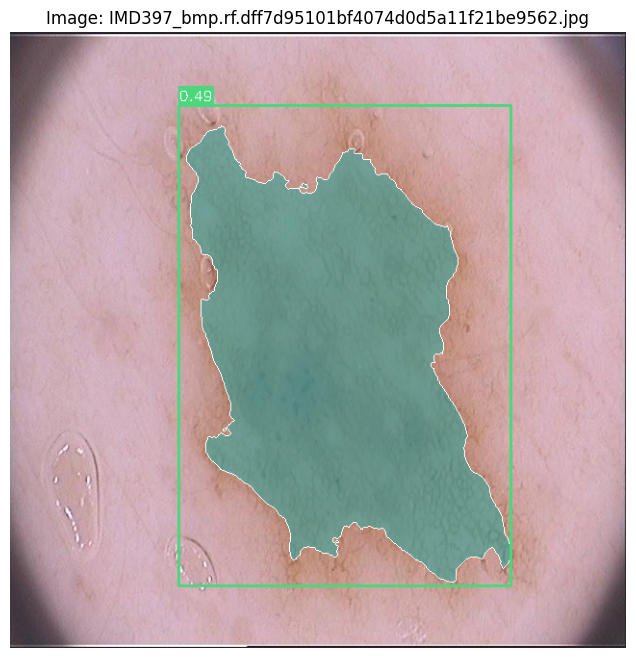

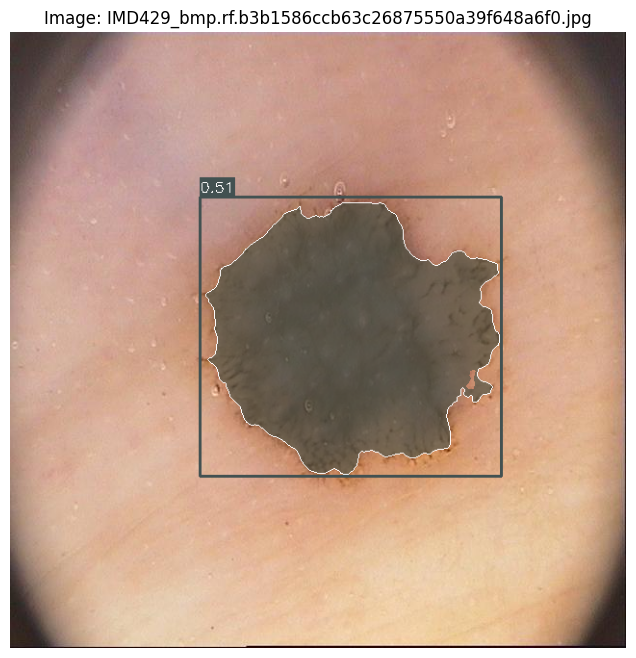

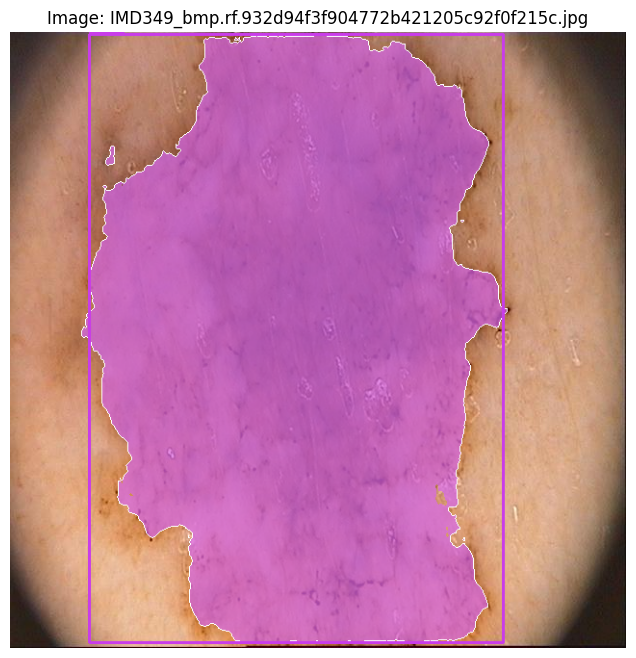

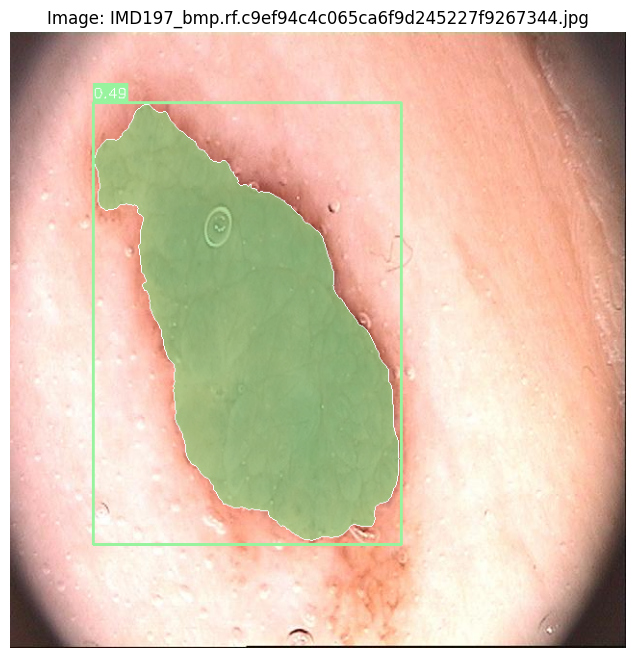

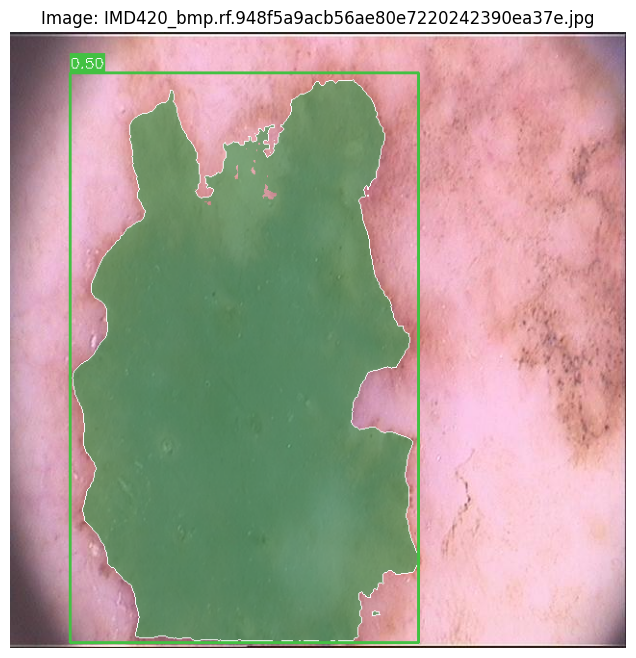

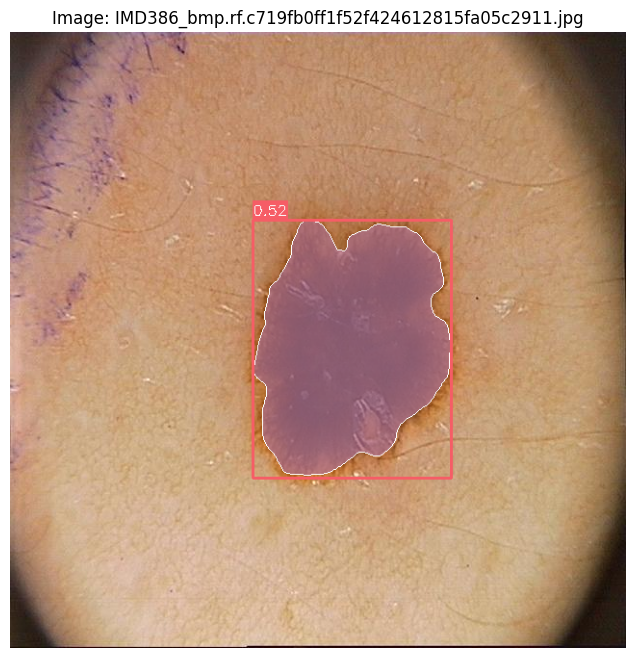

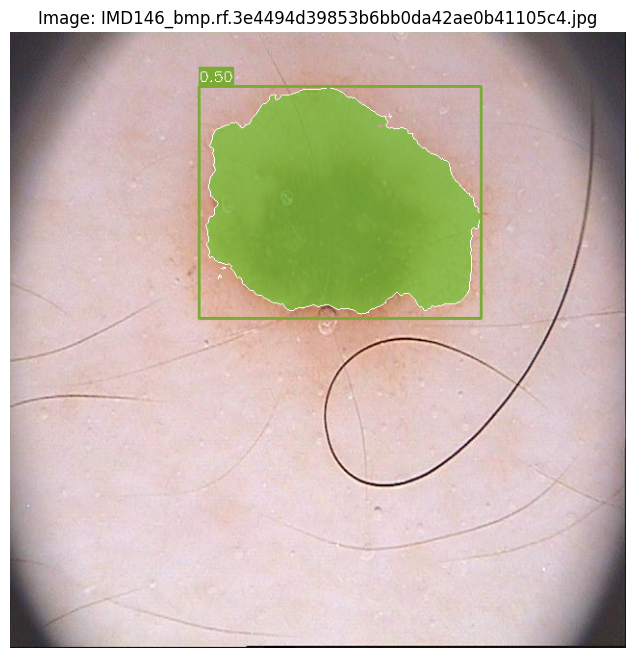

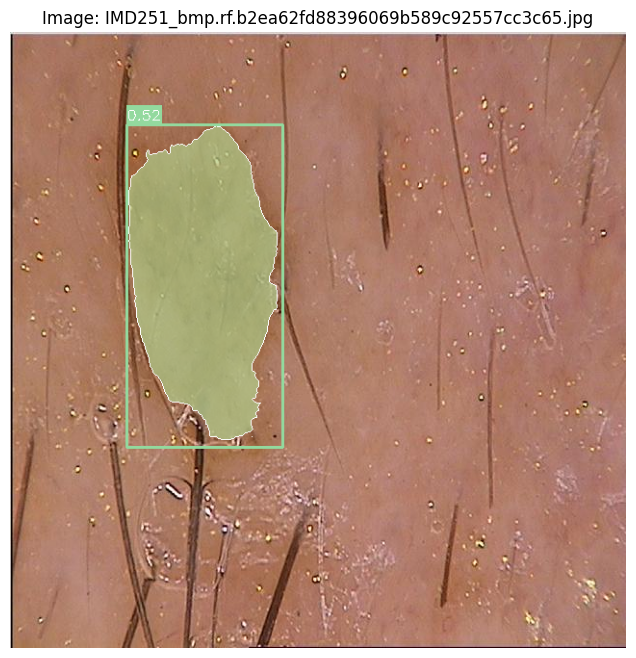

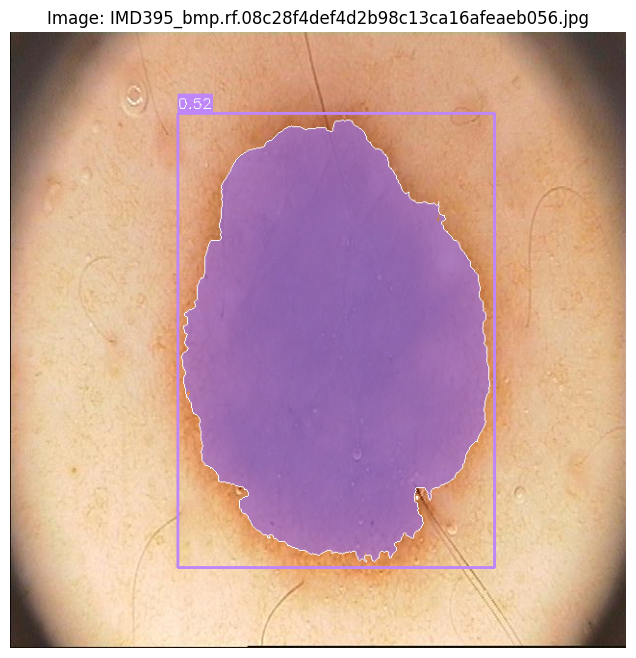

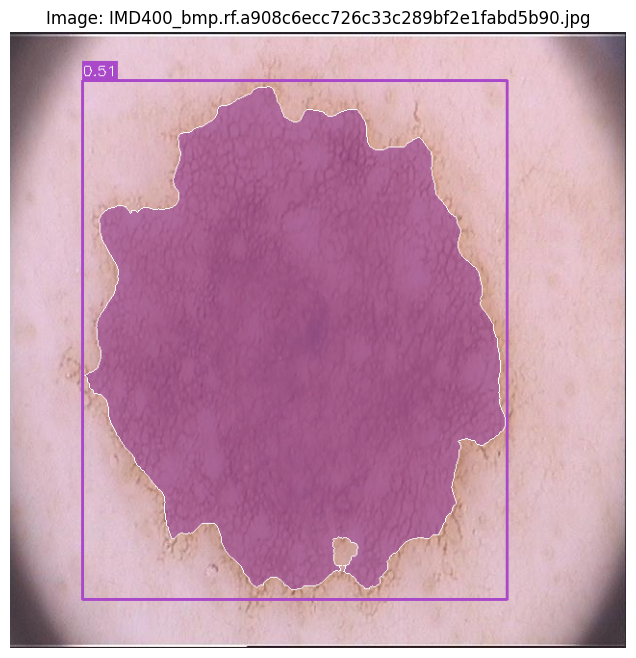

In [6]:
def load_json_data(pred_path: Path, gt_path: Path) -> Tuple[Dict[int, List[Dict]], Dict[int, str]]:
    with open(pred_path, 'r') as f:
        preds = json.load(f)
    preds_map = {}
    for p in preds:
        preds_map.setdefault(p['image_id'], []).append(p)

    if gt_path.exists():
        with open(gt_path, 'r') as f:
            gt = json.load(f)
        id_to_filename = {img['id']: img['file_name'] for img in gt['images']}
    else:
        id_to_filename = None
    return preds_map, id_to_filename

def apply_mask(image: np.ndarray, mask: np.ndarray, color: List[int], alpha: float):
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] * (1 - alpha) + alpha * color[c],
                                  image[:, :, c])
    return image

def draw_visualizations(img: np.ndarray, predictions: List[Dict], threshold: float) -> Tuple[int, np.ndarray]:
    count = 0
    img_h, img_w = img.shape[:2]
    predictions.sort(key=lambda x: x['score']) 

    for pred in predictions:
        score = pred['score']
        if score < threshold: continue

        color = [random.randint(50, 255) for _ in range(3)]
        
        # Máscara
        if 'segmentation' in pred:
            try:
                rle = pred['segmentation']
                binary_mask = mask_utils.decode(rle)
                if binary_mask.shape[:2] != (img_h, img_w):
                    binary_mask = cv2.resize(binary_mask, (img_w, img_h), interpolation=cv2.INTER_NEAREST)
                img = apply_mask(img, binary_mask, color, CONFIG["mask_alpha"])
                contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                cv2.drawContours(img, contours, -1, (255, 255, 255), 1)
            except Exception as e:
                pass

        # Bounding Box
        bbox = pred['bbox']
        if all(v <= 1.1 for v in bbox):
            x, y, w, h = int(bbox[0]*img_w), int(bbox[1]*img_h), int(bbox[2]*img_w), int(bbox[3]*img_h)
        else:
            x, y, w, h = map(int, bbox)
            
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        label = f"{score:.2f}"
        (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(img, (x, y - 20), (x + tw, y), color, -1)
        cv2.putText(img, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        count += 1
        
    return count, img

NUM_IMAGES_TO_SHOW = 10

preds_map, id_to_filename = load_json_data(CONFIG["pred_json"], CONFIG["gt_json"])
shown = 0

for img_id, predictions in preds_map.items():
    if shown >= NUM_IMAGES_TO_SHOW:
        break
        
    if id_to_filename and img_id in id_to_filename:
        img_path = CONFIG["images_dir"] / id_to_filename[img_id]
        if not img_path.exists():
            continue
            
        img = cv2.imread(str(img_path))
        if img is None:
            continue
            
        drawn_count, visual_img = draw_visualizations(img.copy(), predictions, CONFIG["score_threshold"])
        
        if drawn_count > 0:
            # Converte BGR (OpenCV) para RGB (Matplotlib)
            visual_img_rgb = cv2.cvtColor(visual_img, cv2.COLOR_BGR2RGB)
            
            plt.figure(figsize=(8, 8))
            plt.imshow(visual_img_rgb)
            plt.title(f"Image: {id_to_filename[img_id]}")
            plt.axis('off')
            plt.show()
            
            shown += 1